**First Section: train using cross entropy loss**





**code explanation:** frst we load the CIFAR10 dataset and select two classes of that(airplane and automobile). Then load the alexnet model and adjust the last layer due to classes number. After that we init the weights in classifier section. Finally, we train the model and plot accuracy and loss during training. Also we calculate and show the accuracy on test data.

*Please note that no matter you freeze convolutional layers(or feature section) probably due to gradient vanishing.*

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, Loss: 0.5535010246310038, Accuracy: 91.55%
Epoch 2/5, Loss: 0.12280456351336484, Accuracy: 95.41%
Epoch 3/5, Loss: 0.11394923712913924, Accuracy: 95.63%
Epoch 4/5, Loss: 0.09896141150594352, Accuracy: 96.24%
Epoch 5/5, Loss: 0.09412544149088677, Accuracy: 96.44%


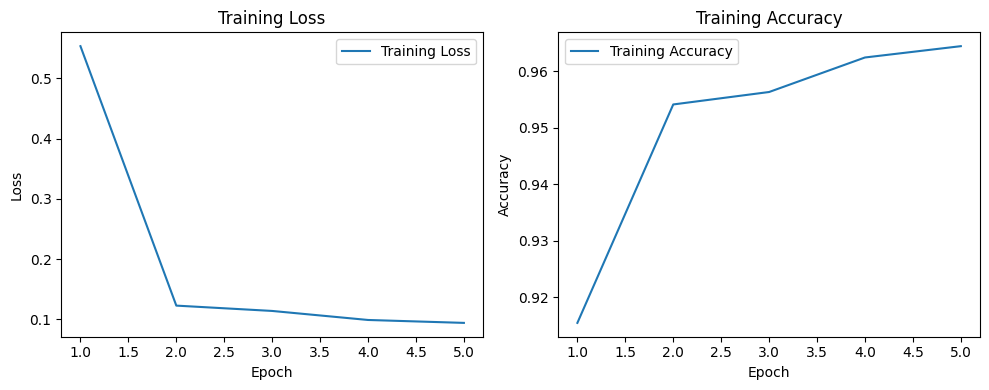

Accuracy on test set: 96.45%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the classes to keep
classes_to_keep = ['airplane', 'automobile']

# Load CIFAR-10 dataset and filter the classes
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to include only 'airplane' and 'automobile' classes
train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(len(train_dataset)) if train_dataset.targets[i] in [0, 1]])

# Filter the test dataset as well
test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(len(test_dataset)) if test_dataset.targets[i] in [0, 1]])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained AlexNet model
alexnet_model = torchvision.models.alexnet(weights='AlexNet_Weights.DEFAULT')

# # Freeze the convolutional layers
# for param in alexnet_model.features.parameters():
#     param.requires_grad = False

# Modify the last layer for binary classification
in_features = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(in_features, 2)


# Initialize the entire classifier with random weights for binary classification
for layer in alexnet_model.classifier.children():
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model.to(device)

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {100 * epoch_accuracy:.2f}%")

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
alexnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {100 * accuracy:.2f}%")


**Second Section: train feature section using triplet loss**



in this section, first, we train feature section and then train classifier like previous cell.

**code explanation:** like previous cell we prepare the CIFAR10 dataset. then we define a function to generate triplet. the function choose a random image in the same class as positive and opposite class as negative. Then we train the feature part using TripletMarginLoss(margin=1). Finally, we train the classifier using cros entropy loss.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/4, Triplet Loss: 0.6834034603273496
Epoch 2/4, Triplet Loss: 0.5931648484331323
Epoch 3/4, Triplet Loss: 0.4789414399612986
Epoch 4/4, Triplet Loss: 0.40971406251363224


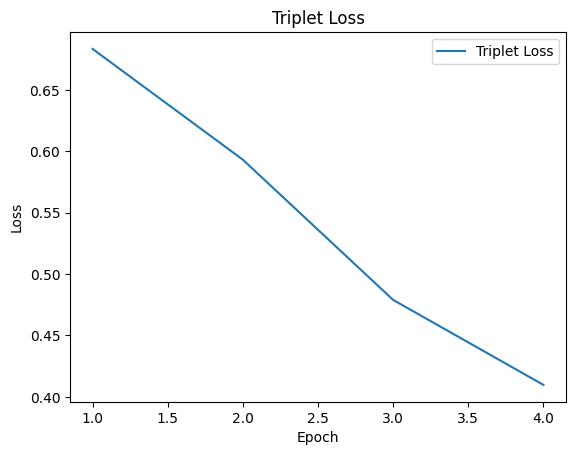

Epoch 1/3, Classifier Loss: 0.8872820373092589, Accuracy: 85.16%
Epoch 2/3, Classifier Loss: 0.5461940150365233, Accuracy: 86.89%
Epoch 3/3, Classifier Loss: 0.48904415313629435, Accuracy: 88.28%


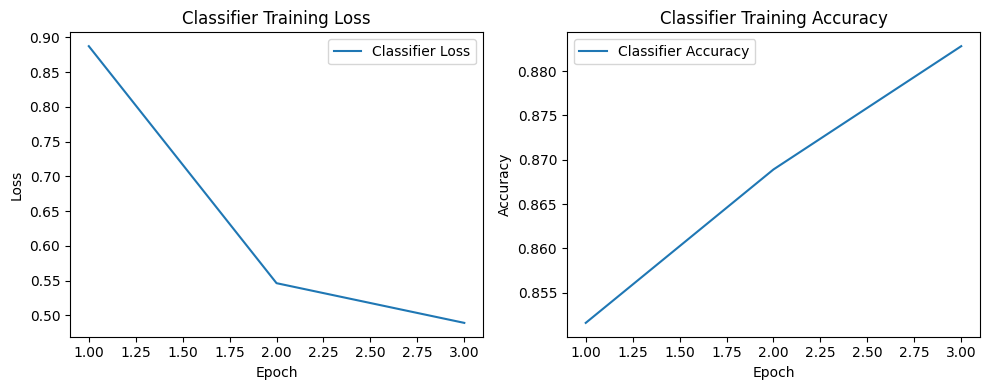

Accuracy on test set: 94.75%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Define the classes to keep
classes_to_keep = ['airplane', 'automobile']

# Load CIFAR-10 dataset and filter the classes
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to include only 'airplane' and 'automobile' classes
train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(len(train_dataset)) if train_dataset.targets[i] in [0, 1]])

# Filter the test dataset as well
test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(len(test_dataset)) if test_dataset.targets[i] in [0, 1]])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to generate triplets
def generate_triplets(labels):
    triplets = []
    for i, anchor_label in enumerate(labels):
        positive_candidates = [j for j, label in enumerate(labels) if label == anchor_label]
        negative_candidates = [j for j, label in enumerate(labels) if label != anchor_label]

        if not positive_candidates or not negative_candidates:
            continue

        anchor = i
        positive = random.choice(positive_candidates)
        negative = random.choice(negative_candidates)

        triplets.append((anchor, positive, negative))

    return triplets

# Load pre-trained AlexNet model
alexnet_model = torchvision.models.alexnet(weights=True)

# Modify the last layer for binary classification
in_features = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(in_features, 2)


features_section = alexnet_model.features
classifier_section = alexnet_model.classifier


triplet_loss_criterion = torch.nn.TripletMarginLoss(margin=1)

# Define optimizer for the features section
optimizer_features = optim.Adam(features_section.parameters(), lr=1e-4)

# Training loop for learning the features section with triplet loss
num_epochs_triplet = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features_section.to(device)
classifier_section.to(device)

train_losses_triplet = []

for epoch in range(num_epochs_triplet):
    features_section.train()
    classifier_section.eval() # Freeze the classifier section
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate triplets
        triplets = generate_triplets(labels)

        if not triplets:
            continue

        # Zero the gradients for the features section
        optimizer_features.zero_grad()

        # Extract features for anchor, positive, and negative
        anchor_features = features_section(inputs[triplets[0][0]].unsqueeze(0))
        positive_features = features_section(inputs[triplets[0][1]].unsqueeze(0))
        negative_features = features_section(inputs[triplets[0][2]].unsqueeze(0))

        # Calculate triplet loss
        loss_triplet = triplet_loss_criterion(anchor_features, positive_features, negative_features)

        # Backward pass and optimization for the features section
        loss_triplet.backward()
        optimizer_features.step()

        running_loss += loss_triplet.item()

    epoch_loss_triplet = running_loss / len(train_loader)
    train_losses_triplet.append(epoch_loss_triplet)

    print(f"Epoch {epoch+1}/{num_epochs_triplet}, Triplet Loss: {epoch_loss_triplet}")

# Plotting triplet loss
plt.plot(range(1, num_epochs_triplet + 1), train_losses_triplet, label='Triplet Loss')
plt.title('Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Define cross-entropy loss and optimizer for the classifier section
classification_criterion = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(classifier_section.parameters(), lr=0.002)


# Training loop for learning the classifier section with cross-entropy loss
num_epochs_classifier = 3

train_losses_classifier = []
train_accuracies_classifier = []

for epoch in range(num_epochs_classifier):
    features_section.eval()  # Freeze the features section
    classifier_section.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients for the classifier
        optimizer_classifier.zero_grad()

        # Extract features using the frozen features section
        with torch.no_grad():
            features = features_section(inputs)

        # Classify features using the classifier section
        outputs_classifier = classifier_section(features.view(features.size(0), -1))

        # Calculate cross-entropy loss
        loss_classifier = classification_criterion(outputs_classifier, labels)

        # Backward pass and optimization for the classifier
        loss_classifier.backward()
        optimizer_classifier.step()

        running_loss += loss_classifier.item()

        _, predicted = torch.max(outputs_classifier.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss_classifier = running_loss / len(train_loader)
    epoch_accuracy_classifier = correct / total

    train_losses_classifier.append(epoch_loss_classifier)
    train_accuracies_classifier.append(epoch_accuracy_classifier)

    print(f"Epoch {epoch+1}/{num_epochs_classifier}, Classifier Loss: {epoch_loss_classifier}, Accuracy: {100 * epoch_accuracy_classifier:.2f}%")

# Plotting classifier loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_classifier + 1), train_losses_classifier, label='Classifier Loss')
plt.title('Classifier Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_classifier + 1), train_accuracies_classifier, label='Classifier Accuracy')
plt.title('Classifier Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation on the test dataset
features_section.eval()
classifier_section.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Extract features using the frozen features section
        features = features_section(inputs)

        # Classify features using the classifier section
        outputs_classifier = classifier_section(features.view(features.size(0), -1))

        # Calculate accuracy
        _, predicted = torch.max(outputs_classifier.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Accuracy on test set: {100 * test_accuracy:.2f}%")



**Third Section: train whole of model using both losses simultaneously**

unlike two previous cells, we aim to consider sum of triplet loss and cross entropy loss as our loss. Obviously, we train both parts simultaneously not separately. Suprisingly, we get a really high accuracy using this novelity!

**code explanation:** there is nothing new here!

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/7, Triplet Loss: 0.67, Classifier Loss: 0.15657661977093668
Epoch 2/7, Triplet Loss: 0.52, Classifier Loss: 0.09402528875325807
Epoch 3/7, Triplet Loss: 0.40, Classifier Loss: 0.08052751857409021
Epoch 4/7, Triplet Loss: 0.31, Classifier Loss: 0.0683904198062024
Epoch 5/7, Triplet Loss: 0.33, Classifier Loss: 0.05858724308474375
Epoch 6/7, Triplet Loss: 0.30, Classifier Loss: 0.048595092001568994
Epoch 7/7, Triplet Loss: 0.27, Classifier Loss: 0.05260410404381255


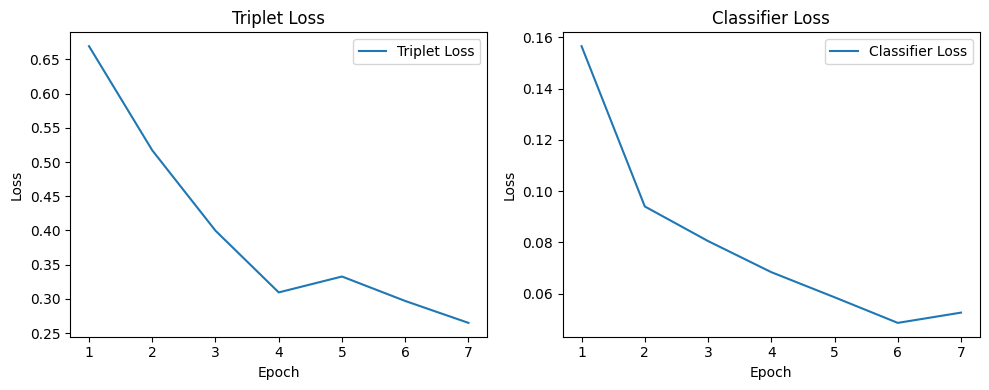

Accuracy on test set: 98.60%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Define the classes to keep
classes_to_keep = ['airplane', 'automobile']

# Load CIFAR-10 dataset and filter the classes
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to include only 'airplane' and 'automobile' classes
train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(len(train_dataset)) if train_dataset.targets[i] in [0, 1]])

# Filter the test dataset as well
test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(len(test_dataset)) if test_dataset.targets[i] in [0, 1]])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to generate triplets
def generate_triplets(labels):
    triplets = []
    for i, anchor_label in enumerate(labels):
        positive_candidates = [j for j, label in enumerate(labels) if label == anchor_label]
        negative_candidates = [j for j, label in enumerate(labels) if label != anchor_label]

        if not positive_candidates or not negative_candidates:
            continue

        anchor = i
        positive = random.choice(positive_candidates)
        negative = random.choice(negative_candidates)

        triplets.append((anchor, positive, negative))

    return triplets

# Load pre-trained AlexNet model
alexnet_model = torchvision.models.alexnet(weights=True)

# Modify the last layer for binary classification
in_features = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(in_features, 2)

# Extract the features section and classifier section
features_section = alexnet_model.features
classifier_section = alexnet_model.classifier

# Define the triplet loss
triplet_loss_criterion = torch.nn.TripletMarginLoss(margin=1)

# Define the optimizer for the entire model
optimizer_total = optim.Adam(alexnet_model.parameters(), lr=1e-4)

# Training loop for learning both sections with triplet loss and cross-entropy loss
num_epochs_total = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model.to(device)

train_losses_total = []

for epoch in range(num_epochs_total):
    features_section.train()
    classifier_section.train()
    running_loss_triplet = 0.0
    running_loss_classifier = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate triplets
        triplets = generate_triplets(labels)

        if not triplets:
            continue

        # Zero the gradients for the entire model
        optimizer_total.zero_grad()

        # Extract features for anchor, positive, and negative
        anchor_features = features_section(inputs[triplets[0][0]].unsqueeze(0))
        positive_features = features_section(inputs[triplets[0][1]].unsqueeze(0))
        negative_features = features_section(inputs[triplets[0][2]].unsqueeze(0))

        # Calculate triplet loss
        loss_triplet = triplet_loss_criterion(anchor_features, positive_features, negative_features)

        # Classify features using the classifier section
        outputs_classifier = classifier_section(features_section(inputs).view(inputs.size(0), -1))

        # Calculate cross-entropy loss
        loss_classifier = F.cross_entropy(outputs_classifier, labels)

        # Calculate total loss
        loss_total = loss_triplet + loss_classifier

        # Backward pass and optimization for the entire model
        loss_total.backward()
        optimizer_total.step()

        running_loss_triplet += loss_triplet.item()
        running_loss_classifier += loss_classifier.item()

    epoch_loss_triplet = running_loss_triplet / len(train_loader)
    epoch_loss_classifier = running_loss_classifier / len(train_loader)
    train_losses_total.append((epoch_loss_triplet, epoch_loss_classifier))

    print(f"Epoch {epoch+1}/{num_epochs_total}, Triplet Loss: {epoch_loss_triplet:.2f}, Classifier Loss: {epoch_loss_classifier}")

# Plotting triplet loss and classifier loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_total + 1), [t[0] for t in train_losses_total], label='Triplet Loss')
plt.title('Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_total + 1), [t[1] for t in train_losses_total], label='Classifier Loss')
plt.title('Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluation on the test dataset
features_section.eval()
classifier_section.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Extract features using the frozen features section
        features = features_section(inputs)

        # Classify features using the classifier section
        outputs_classifier = classifier_section(features.view(features.size(0), -1))

        # Calculate accuracy
        _, predicted = torch.max(outputs_classifier.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Accuracy on test set: {100 * test_accuracy:.2f}%")
